In [1]:
import numpy as np
import random
seed = 666
random.seed(seed)
np.random.seed(seed)

import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.neighbors import KernelDensity
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score

from clusterless import data_preprocess
from clusterless import viz_tools
from clusterless import init_gmm
from clusterless import split_merge
from clusterless import smooth_signals
from clusterless import decode_static

load data

In [2]:
rootpath = "../data"
sub_id = "dy009"
samp_freq = 30_000

In [3]:
# load unsorted data
spikes_indices, spikes_features, np1_channel_map, stimulus_onset_times, unsorted, trials = \
    data_preprocess.load_unsorted_data(rootpath, sub_id, roi='all', keep_active_trials=True, samp_freq=samp_freq)

In [4]:
behave_dict, behave_idx_dict = data_preprocess.load_behaviors_data(rootpath, sub_id)

In [5]:
choices, stimuli, transformed_stimuli, one_hot_stimuli, enc_categories, rewards, priors = data_preprocess.preprocess_static_behaviors(behave_dict, keep_active_trials = True)

choices left: 0.361, right: 0.639
stimuli left: 0.430, right: 0.570
reward wrong: 0.087, correct: 0.913


initialize gmm using k-means++ (recommended and faster than k-means)

In [6]:
trials_ids = np.arange(len(trials))
structured_unsorted = np.vstack([trials[i] for i in trials_ids])[:,1:] # follows time order

In [7]:
initial_gmm = init_gmm.initial_gaussian_mixtures('..', sub_id, trials, n_gaussians=400, seed=seed, fit_model=False)

In [8]:
initial_labels = initial_gmm.predict(structured_unsorted)
initial_probs = initial_gmm.predict_proba(structured_unsorted)

In [9]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, initial_labels, initial_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 400, 30)
clusterless neural projections shape: (230, 400, 15)
clusterless neural reconstructions shape: (230, 400, 30)


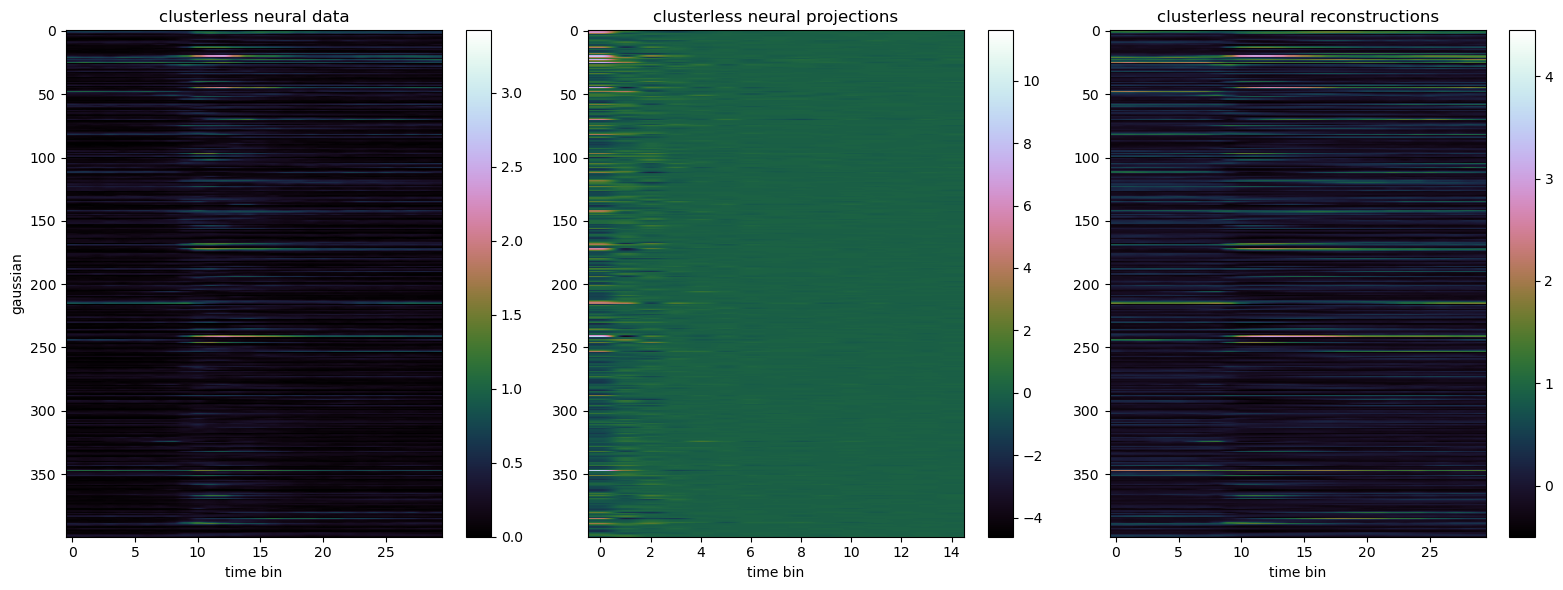

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [11]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.985
choice fold 2 test accuracy: 0.957 auc: 0.981
choice fold 3 test accuracy: 0.957 auc: 0.992
choice fold 4 test accuracy: 0.935 auc: 0.982
choice fold 5 test accuracy: 0.978 auc: 1.000
choice mean of 5-fold cv accuracy: 0.948 auc: 0.988
choice sd of 5-fold cv accuracy: 0.022 auc: 0.007
stimulus fold 1 test accuracy: 0.261 auc: 0.785
stimulus fold 2 test accuracy: 0.239 auc: 0.790
stimulus fold 3 test accuracy: 0.391 auc: 0.828
stimulus fold 4 test accuracy: 0.261 auc: 0.800
stimulus fold 5 test accuracy: 0.370 auc: 0.815
stimulus mean of 5-fold cv accuracy: 0.304 auc: 0.804
stimulus sd of 5-fold cv accuracy: 0.063 auc: 0.016


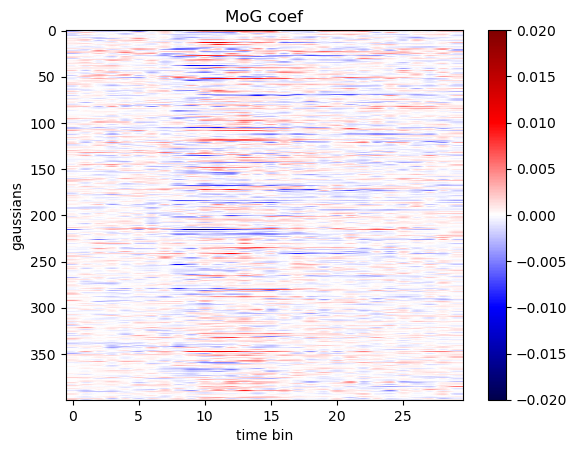

In [12]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()

identify gaussians with large feature spread ...

In [13]:
from scipy.interpolate import UnivariateSpline
from clusterless.data_preprocess import load_kilosort_template_feature_mads

def calc_mad(arr):
    """ 
    median absolute deviation: a "robust" version of standard deviation.
    """
    arr = np.ma.array(arr).compressed() 
    med = np.median(arr)
    return np.median(np.abs(arr - med))

def calc_component_ptp_dependent_feature_mads(data, labels, comp_idx):
    avg_ptp = data[labels == comp_idx][:,-1].mean()
    mad_x = calc_mad(data[labels == comp_idx][:,0])
    mad_z = calc_mad(data[labels == comp_idx][:,1])
    return avg_ptp, mad_x, mad_z

def calc_smooth_envelope_feature_mads(temp_amps, mad_xs, mad_zs, use_ks_template=False):
    '''
    monotonic smoothing envelopes for x and z. 
    to do: change ad hoc smoothing params.
    to do: remove using our features.
    '''
    
    # interpolate x
    offset = mad_xs.copy()
    if use_ks_template:   
        offset[:15] = offset[:15]+1.
        offset[15:20] = offset[15:20]+2.
        offset[20:] = offset[20:]+2.
    else:
        offset[:15] = offset[:15]+6.
        offset[15:20] = offset[15:20]+3.
        offset[20:] = offset[20:]+1.
    xs = np.linspace(temp_amps.min(), temp_amps.max(), 6)
    spl1 = UnivariateSpline(temp_amps, offset)
    spl2 = UnivariateSpline(xs, spl1(xs))
    xs2 = np.linspace(xs.min(), xs.max(), 40)
    envelope_xs = spl2(xs2)
    
    # interpolate z
    offset = mad_zs.copy()
    if use_ks_template: 
        offset[:15] = offset[:15]+3
        offset[15:20] = offset[15:20]+1
        offset[20:] = offset[20:]+2.
        zs = np.linspace(temp_amps.min(), temp_amps.max(), 6)
    else:
        offset[:15] = offset[:15]+15.
        offset[15:20] = offset[15:20]+10.
        offset[20:] = offset[20:]+3.
        zs = np.linspace(temp_amps.min(), temp_amps.max(), 6)
    spl1 = UnivariateSpline(temp_amps, offset)
    spl2 = UnivariateSpline(zs, spl1(zs))
    zs2 = np.linspace(zs.min(), zs.max(), 40)
    envelope_zs = spl2(zs2)

    return xs2, zs2, envelope_xs, envelope_zs


def split_criteria(data, labels, use_ks_template=False):
    '''
    to do: fix scale mismatch btw kilosort template features and our features.
    to do: remove using our features.
    '''
    
    avg_ptps = []
    mad_xs = []
    mad_zs = []
    for comp_idx in np.unique(labels):
        avg_ptp, mad_x, mad_z = calc_component_ptp_dependent_feature_mads(data, labels, comp_idx)
        avg_ptps.append(avg_ptp)
        mad_xs.append(mad_x)
        mad_zs.append(mad_z)
    avg_ptps = np.array(avg_ptps)
    mad_xs = np.array(mad_xs)
    mad_zs = np.array(mad_zs)
    
    if use_ks_template:
        binned_ptps, binned_xs, binned_zs = load_kilosort_template_feature_mads('../data')
        xs, zs, envelope_xs, envelope_zs = \
        calc_smooth_envelope_feature_mads(binned_ptps, binned_xs, binned_zs, use_ks_template=use_ks_template)
        closest_bin_ids = [np.argmin(np.abs(binned_ptps - ptp)) for ptp in avg_ptps]    
    else:
        for bin_size in range(200):
            ptp_bins = np.linspace(np.min(avg_ptps), np.max(avg_ptps), bin_size) 
            ptp_masks = np.digitize(avg_ptps, ptp_bins, right=True)
            if len(np.unique(ptp_masks)) == 40:
                break
        binned_ptps = np.array([avg_ptps[ptp_masks == bin].mean() for bin in np.unique(ptp_masks)])
        binned_xs = np.array([mad_xs[ptp_masks == bin].mean() for bin in np.unique(ptp_masks)])
        binned_zs = np.array([mad_zs[ptp_masks == bin].mean() for bin in np.unique(ptp_masks)])
        closest_ptp_bins = [np.argmin(np.abs(ptp_bins - ptp)) for ptp in avg_ptps]
        closest_bin_ids = [np.argmin(np.abs(np.unique(ptp_masks) - bin_id)) for bin_id in closest_ptp_bins]
        xs, zs, envelope_xs, envelope_zs = \
        calc_smooth_envelope_feature_mads(binned_ptps, binned_xs, binned_zs, use_ks_template=use_ks_template)
        
    fig, axes = plt.subplots(1,2, figsize=(10,3))
    axes[0].plot(binned_ptps, binned_xs, label='x', linestyle='dashed')
    axes[0].plot(xs, envelope_xs, label='envelope x', linewidth=2)
    axes[0].set_xlabel('template amplitude')
    axes[0].set_ylabel('feature MAD')
    axes[0].legend();
    axes[1].plot(binned_ptps, binned_zs, label='z', linestyle='dashed')
    axes[1].plot(zs, envelope_zs, label='envelope z', linewidth=2)
    axes[1].legend();
    axes[1].set_xlabel('template amplitude')
    plt.tight_layout()
    plt.show()
          
    split_ids = []
    for i in range(len(avg_ptps)):
        if np.logical_or(mad_xs[i] > envelope_xs[closest_bin_ids[i]], 
                         mad_xs[i] > envelope_zs[closest_bin_ids[i]]):
            split_ids.append(i)
            
    residual_labels = list(set(np.unique(labels)).difference(set(split_ids)))
            
    return split_ids, residual_labels

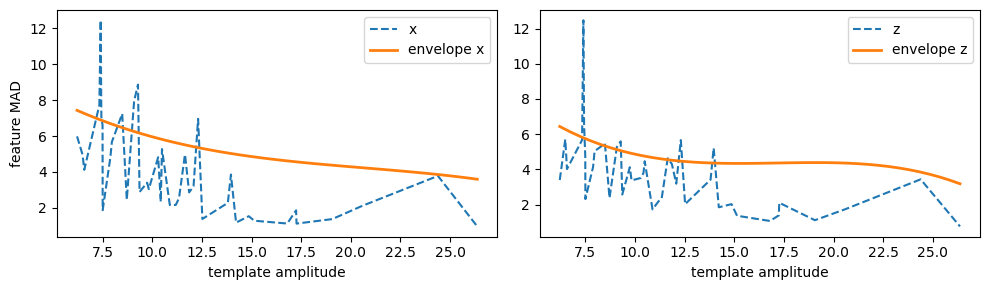

114 286


In [33]:
# plot smooth envelope for kilosort template feature MADs
# split_ids, residual_ids = split_merge.split_criteria(structured_unsorted, initial_labels, use_ks_template=True)
split_ids, residual_ids = split_criteria(structured_unsorted, initial_labels, use_ks_template=True)
print(len(split_ids), len(residual_ids))

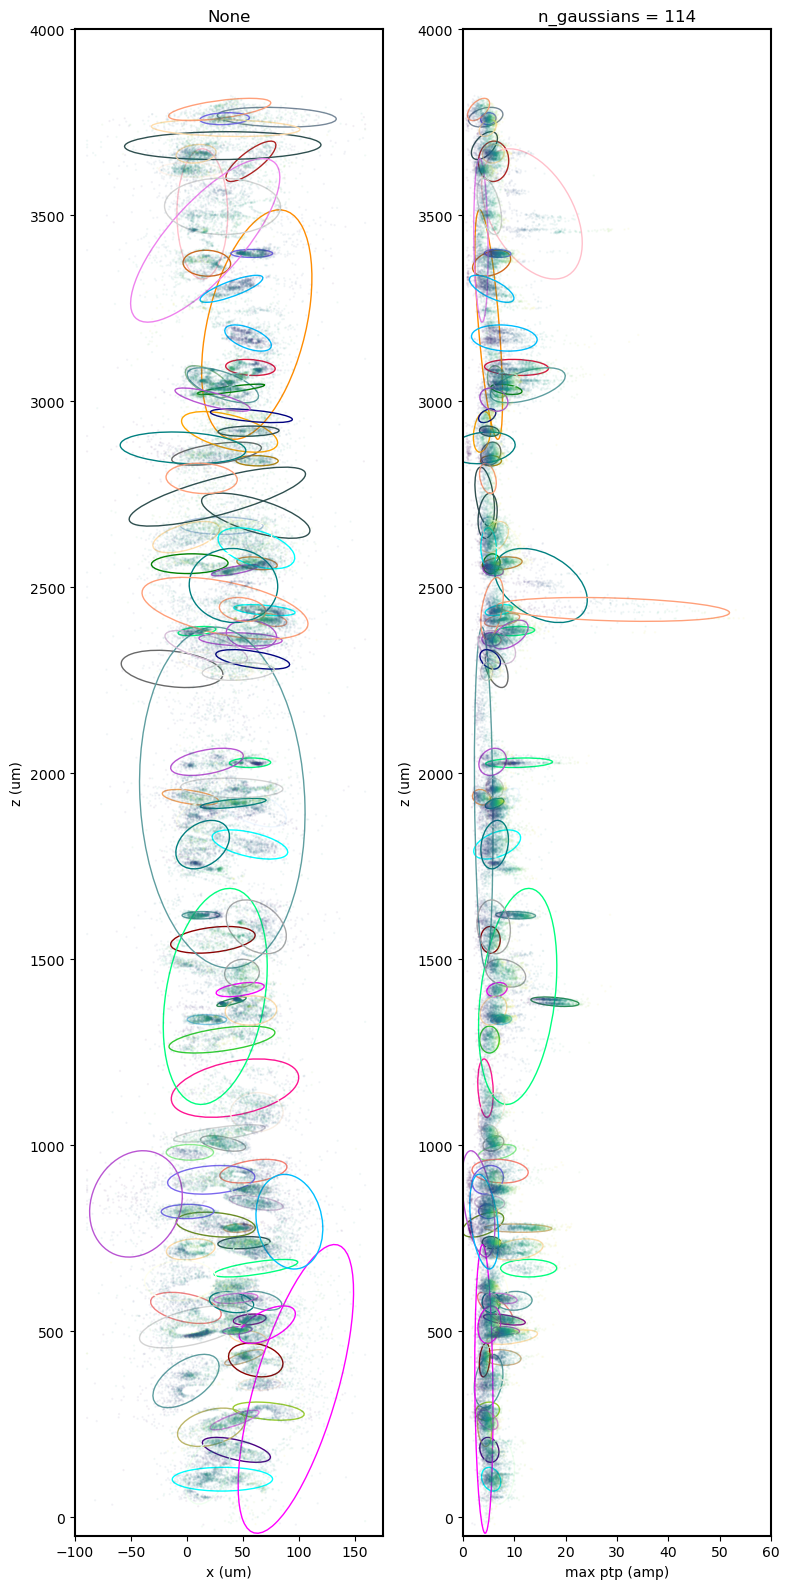

In [34]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, split_ids, display_all_spikes=False, n_spikes_display=1_000)

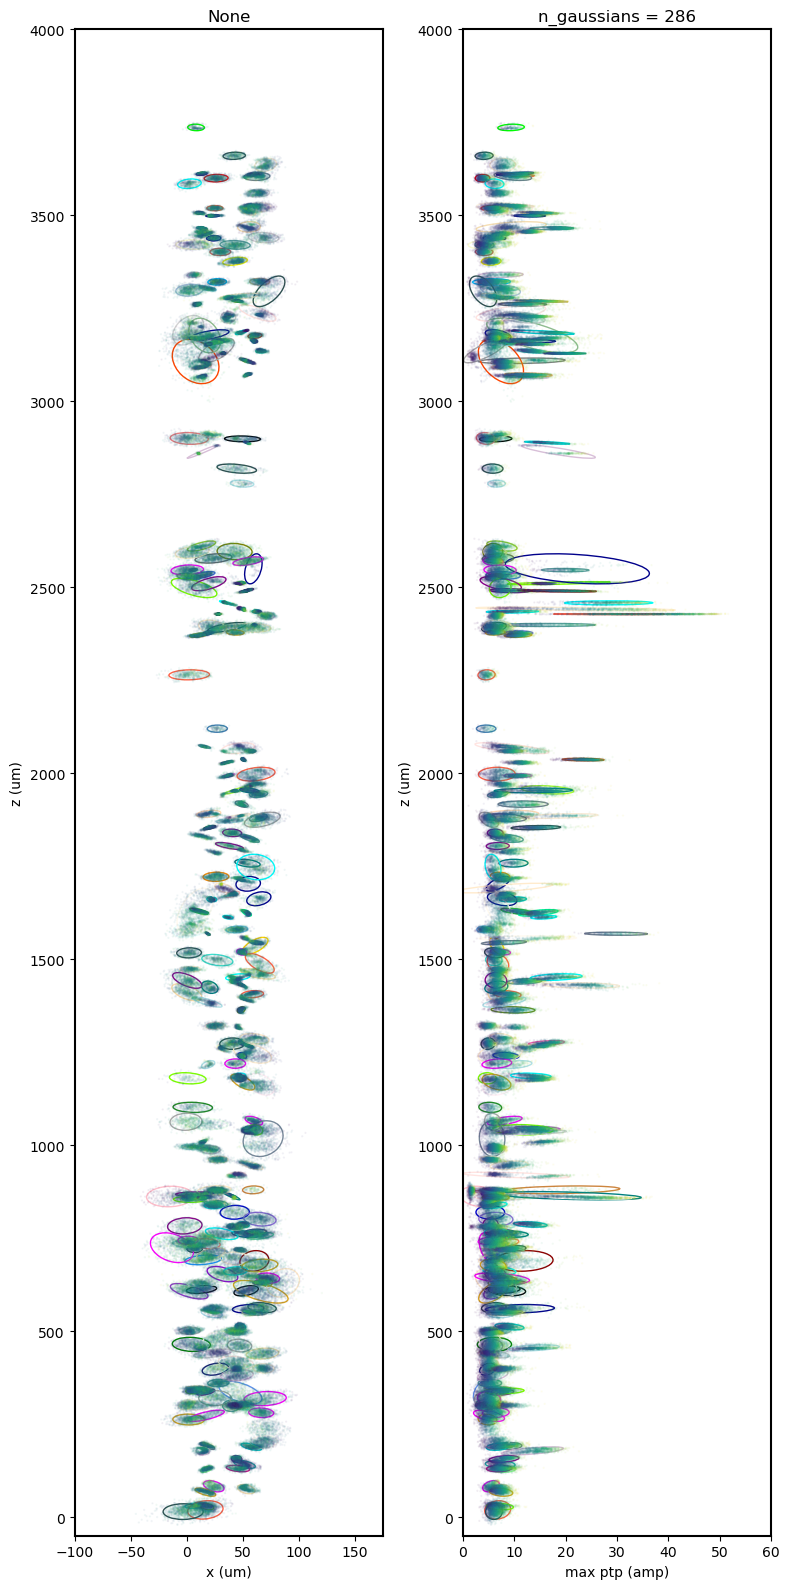

In [35]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, residual_ids, display_all_spikes=False, n_spikes_display=1_000)

identify multi-modal gaussians (unit testing)

In [18]:
def getExtremePoints(data, typeOfInflexion = 'max', maxPoints = None):
    '''
    https://towardsdatascience.com/modality-tests-and-kernel-density-estimations-3f349bb9e595
    '''
    a = np.diff(data)
    asign = np.sign(a)
    signchange = ((np.roll(asign, 1) - asign) != 0).astype(int)
    idx = np.where(signchange ==1)[0]
    if typeOfInflexion == 'max' and data[idx[0]] < data[idx[1]]:
            idx = idx[1:][::2]

    elif typeOfInflexion == 'min' and data[idx[0]] > data[idx[1]]:
        idx = idx[1:][::2]
    elif typeOfInflexion is not None:
        idx = idx[::2]

    # sort ids by min value
    if 0 in idx:
        idx = np.delete(idx, 0)
    if (len(data)-1) in idx:
        idx = np.delete(idx, len(data)-1)
    idx = idx[np.argsort(data[idx])]
    if maxPoints is not None:
        idx= idx[:maxPoints]
        if len(idx) < maxPoints:
            return (np.arange(maxPoints) + 1) * (len(data)//(maxPoints + 1))

    return idx

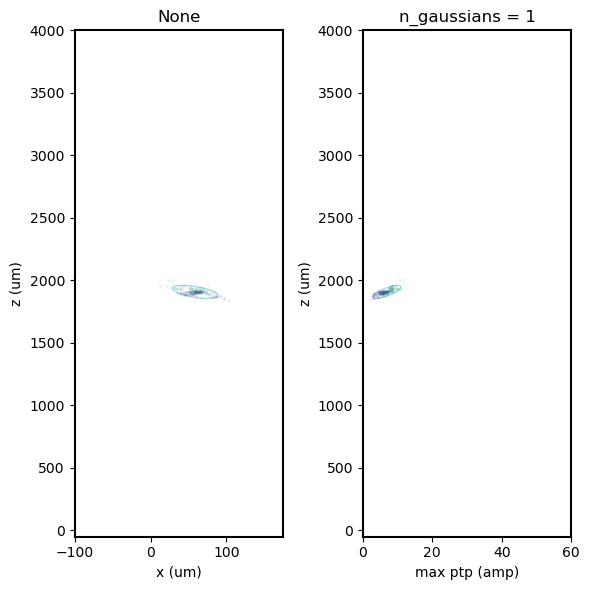

In [36]:
idx = split_ids[0] # -10
sub_spike_train = structured_unsorted[initial_labels == idx]
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, idx, display_all_spikes=True, figure_size=(6,6))

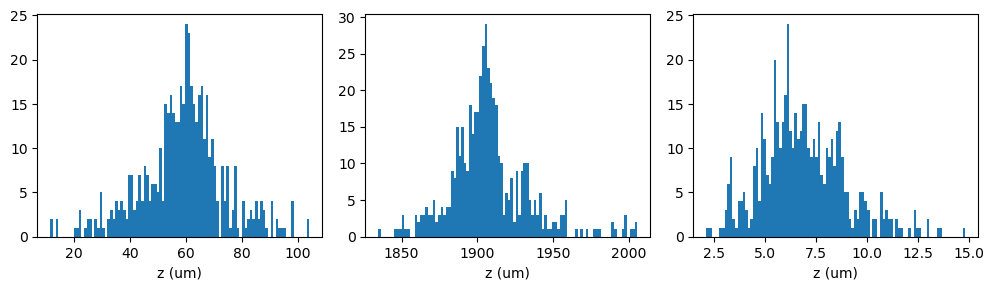

In [37]:
fig, axes = plt.subplots(1,3, figsize=(10,3))
axes[0].hist(sub_spike_train[:,0], 100);
axes[0].set_xlabel('z (um)');
axes[1].hist(sub_spike_train[:,1], 100);
axes[1].set_xlabel('z (um)');
axes[2].hist(sub_spike_train[:,2], 100);
axes[2].set_xlabel('z (um)');
plt.tight_layout()
plt.show()

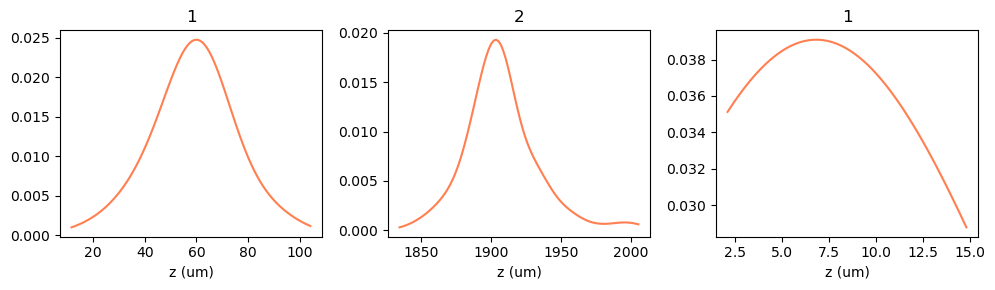

2


In [38]:
fig, axes = plt.subplots(1,3, figsize=(10,3))
n_maxima = []
for i in range(3):
    values = sub_spike_train[:,i].reshape(-1,1)
    xs = np.linspace(np.min(values), np.max(values), 100).reshape(-1,1)
    model = KernelDensity(kernel = 'gaussian', bandwidth=10)
    model.fit(values)
    log_densities = model.score_samples(xs)
    pdfs = np.exp(log_densities)
    n_maxima.append(len(getExtremePoints(pdfs)))
    axes[i].plot(xs, pdfs, c = 'coral');
    axes[i].set_xlabel('z (um)');
    axes[i].set_title(f'{n_maxima[i]}')
plt.tight_layout()
plt.show()
n_gaussians = np.max(n_maxima)
if n_gaussians > 4:
    n_gaussians = n_gaussians // 2
print(n_gaussians)

In [458]:
# use dirichlet process to choose K for each gaussian to be split
sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          max_iter=1000, covariance_type='tied',
                          init_params='kmeans', warm_start=True, verbose=0).fit(sub_spike_train)

In [459]:
sub_labels = sub_gmm.predict(sub_spike_train)

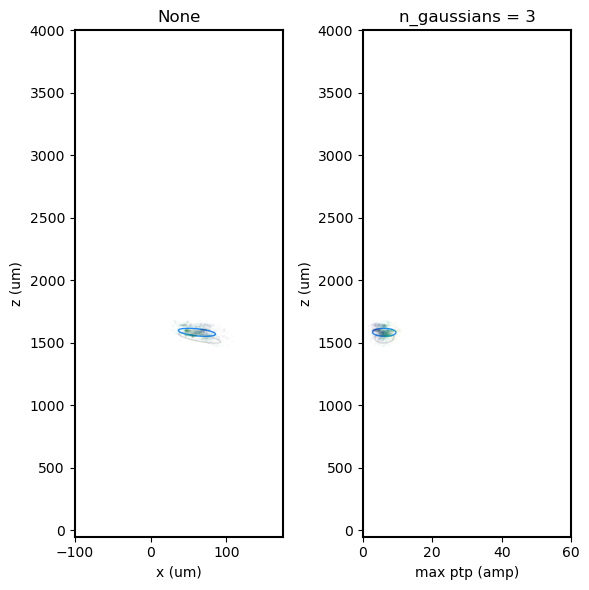

In [460]:
viz_tools.plot_gmm_cluster_bounds(sub_id, sub_spike_train, sub_labels, sub_labels, figure_size=(6,6), display_all_spikes=True)

iterate to do so ...

In [19]:
multi_modal_dict = {}
sub_spike_train_lst = []
sub_weights_lst = []
sub_means_lst = []
sub_covs_lst = []
for idx in range(len(split_ids)):
    sub_spike_train = structured_unsorted[initial_labels == split_ids[idx]]
    sub_spike_train_lst.append(sub_spike_train)
    n_extrema = []
    for ax in range(3):
        values = sub_spike_train[:,ax].reshape(-1,1)
        xs = np.linspace(np.min(values), np.max(values), 100).reshape(-1,1)
        model = KernelDensity(kernel = 'gaussian', bandwidth=10)
        model.fit(values)
        log_densities = model.score_samples(xs)
        pdfs = np.exp(log_densities)
        n_extrema.append(len(getExtremePoints(pdfs)))
    n_gaussians = np.max(n_extrema)
    if n_gaussians > 1:
        if n_gaussians > 3: 
            continue
        multi_modal_dict.update({split_ids[idx]: n_gaussians})
        sub_gmm = GaussianMixture(n_components=n_gaussians, 
                          covariance_type='full',
                          init_params='kmeans', warm_start=True, verbose=0)
        sub_gmm.fit(sub_spike_train)
        sub_weights = np.ones(n_gaussians) * (initial_gmm.weights_[split_ids[idx]] / n_gaussians)
        sub_weights_lst.append(sub_weights)
        sub_means_lst.append(sub_gmm.means_)
        sub_covs_lst.append(sub_gmm.covariances_)

In [20]:
multi_modal_ids = list(multi_modal_dict.keys())
uni_modal_ids = list(set(np.unique(initial_labels)).difference(set(multi_modal_ids)))

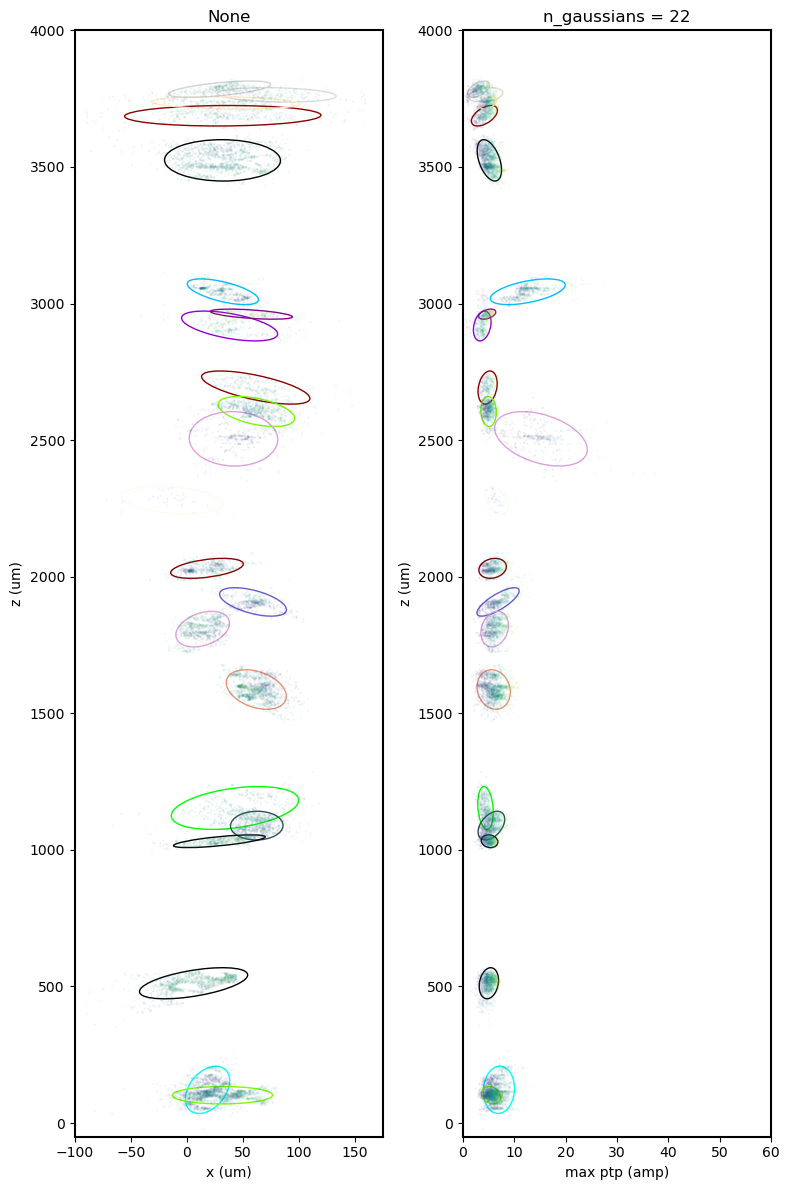

In [21]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, multi_modal_ids, figure_size=(8,12), display_all_spikes=True)

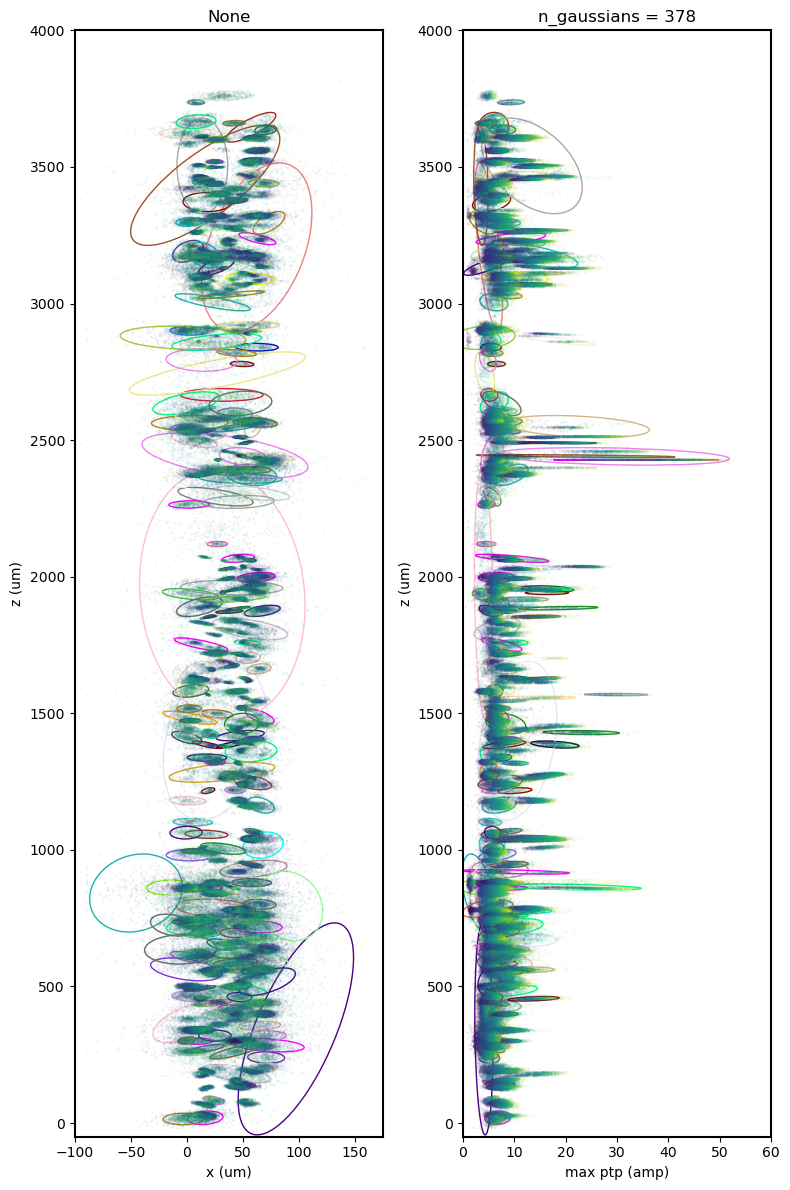

In [22]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, initial_labels, uni_modal_ids, figure_size=(8,12), display_all_spikes=True)

In [23]:
residual_ids = set(np.unique(initial_labels)).difference(set(multi_modal_ids))
print(f'keep {len(residual_ids)} gaussians and split {len(multi_modal_ids)} gaussians ...')

residual_weights = np.vstack([initial_gmm.weights_[i] for i in residual_ids]).squeeze()
residual_means = np.vstack([initial_gmm.means_[i] for i in residual_ids])
residual_covariances = np.stack([initial_gmm.covariances_[i] for i in residual_ids])

residual_gmm = GaussianMixture(n_components=len(residual_ids), covariance_type='full')
residual_gmm.weights_ = residual_weights
residual_gmm.means_ = residual_means
residual_gmm.covariances_ = residual_covariances
residual_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(residual_covariances))

residual_spikes_train = np.vstack([structured_unsorted[initial_labels == idx] for idx in residual_ids])
residual_vars = np.vstack([np.var(structured_unsorted[initial_labels == i], axis=0) for i in residual_ids])

keep 378 gaussians and split 22 gaussians ...


In [24]:
sub_weights = np.hstack(sub_weights_lst)
sub_means = np.vstack(sub_means_lst)
sub_covs = np.vstack(sub_covs_lst)

In [25]:
post_split_weights = np.hstack([residual_gmm.weights_, sub_weights])
post_split_means = np.vstack([residual_gmm.means_, sub_means])
post_split_covariances = np.vstack([residual_gmm.covariances_, sub_covs])

post_split_gmm = GaussianMixture(n_components=len(post_split_weights), covariance_type='full')
post_split_gmm.weights_ = post_split_weights
post_split_gmm.means_ = post_split_means
post_split_gmm.covariances_ = post_split_covariances
post_split_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(post_split_covariances))

In [26]:
post_split_labels = post_split_gmm.predict(structured_unsorted)
post_split_probs = post_split_gmm.predict_proba(structured_unsorted)

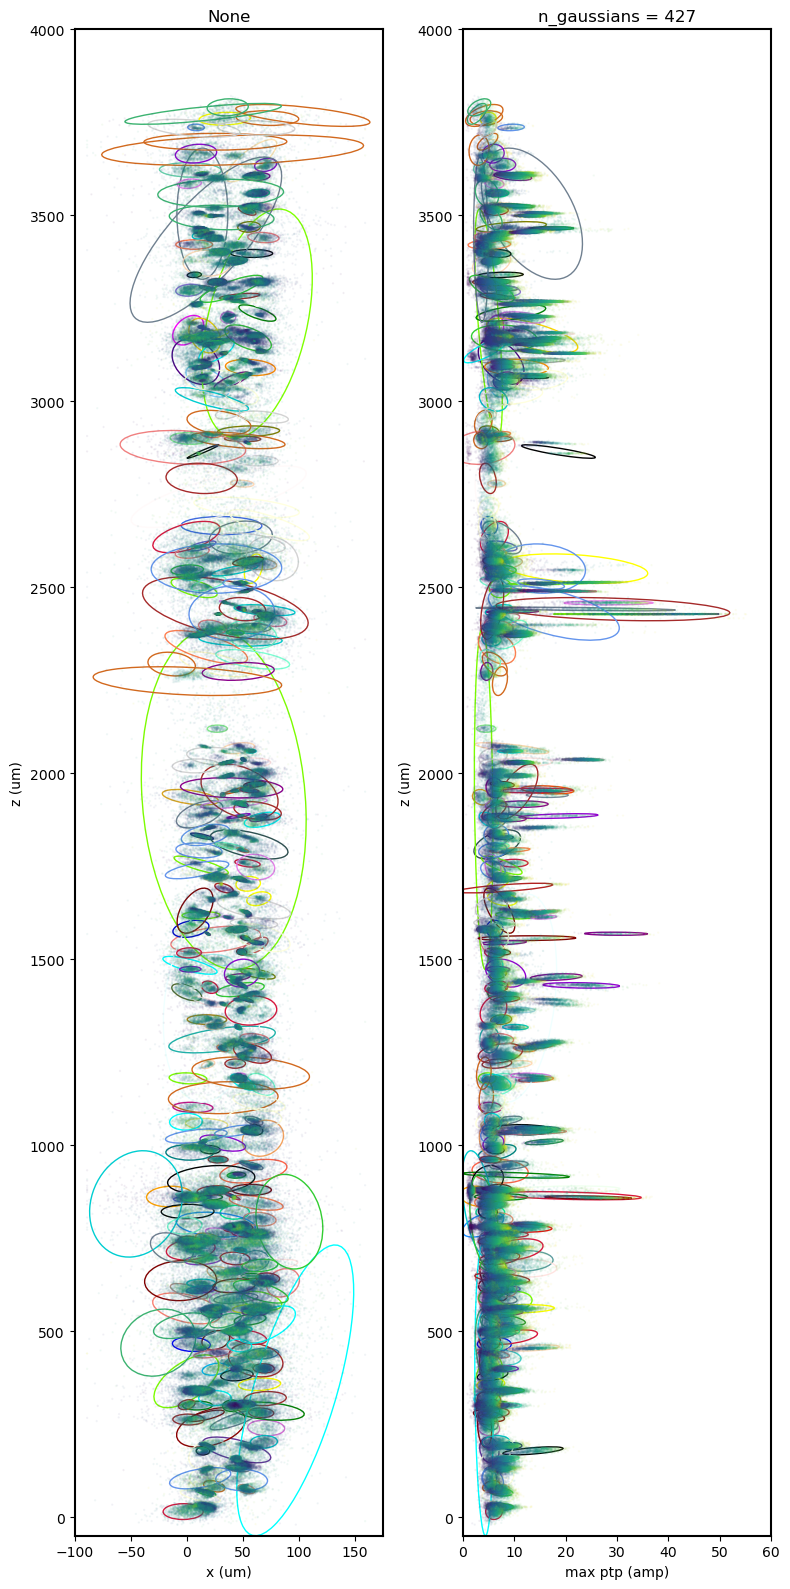

In [27]:
viz_tools.plot_gmm_cluster_bounds(sub_id, structured_unsorted, post_split_labels, post_split_labels, display_all_spikes=False, n_spikes_display=5_000)

In [28]:
trials_ids = np.arange(len(trials))
spikes_times = np.vstack([trials[i] for i in trials_ids])[:,0]

clusterless_neural_data = data_preprocess.\
    compute_time_binned_neural_activity((spikes_times, post_split_labels, post_split_probs), 
                                            'clusterless', stimulus_onset_times, regional=False)
clusterless_tpca_proj, clusterless_tpca_recon = smooth_signals.tpca(clusterless_neural_data, n_projs=15)
print(f'clusterless neural data shape: {clusterless_neural_data.shape}')
print(f'clusterless neural projections shape: {clusterless_tpca_proj.shape}')
print(f'clusterless neural reconstructions shape: {clusterless_tpca_recon.shape}')

clusterless neural data shape: (230, 427, 30)
clusterless neural projections shape: (230, 427, 15)
clusterless neural reconstructions shape: (230, 427, 30)


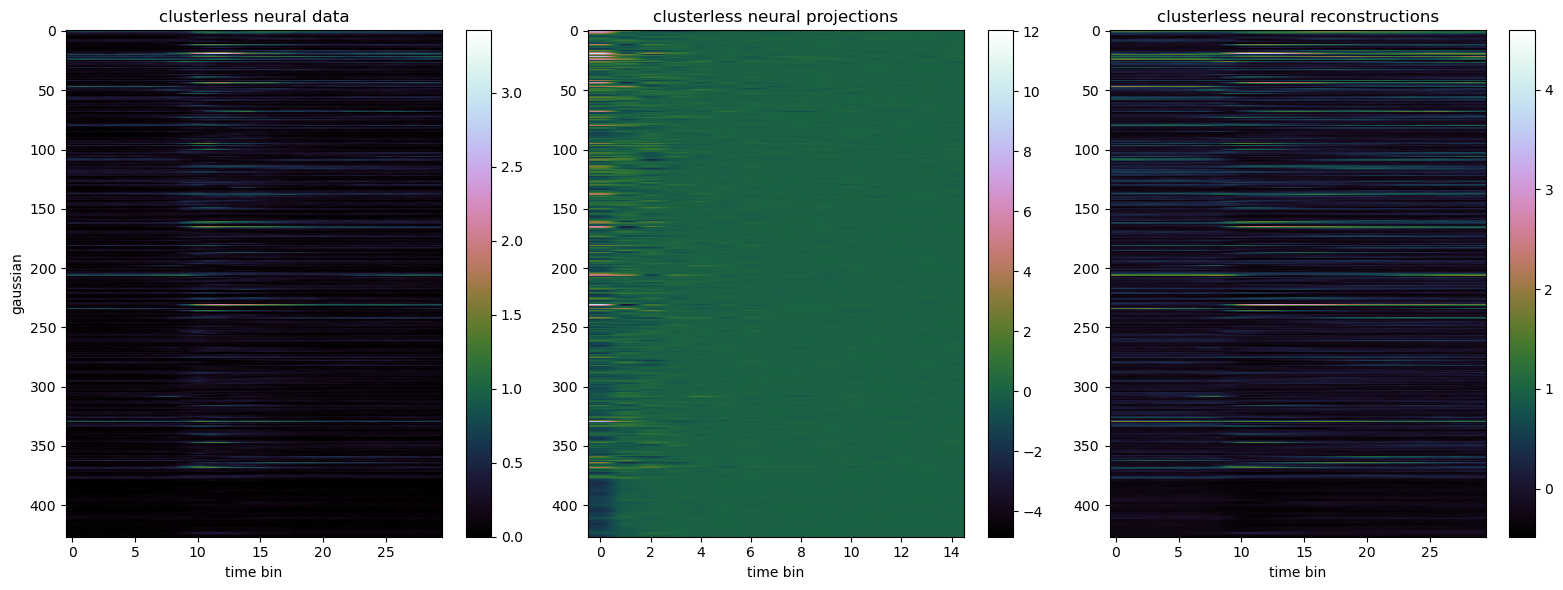

In [29]:
fig, axes = plt.subplots(1, 3, figsize=(16,6))

p1 = axes[0].imshow(clusterless_neural_data.mean(0), aspect='auto', cmap='cubehelix')
axes[0].set_title('clusterless neural data')
axes[0].set_xlabel('time bin')
axes[0].set_ylabel('gaussian')
plt.colorbar(p1, ax=axes[0]);

p2 = axes[1].imshow(clusterless_tpca_proj.mean(0), aspect='auto', cmap='cubehelix')
axes[1].set_title('clusterless neural projections')
axes[1].set_xlabel('time bin')
plt.colorbar(p2, ax=axes[1]);

p3 = axes[2].imshow(clusterless_tpca_recon.mean(0), aspect='auto', cmap='cubehelix')
axes[2].set_title('clusterless neural reconstructions')
axes[2].set_xlabel('time bin')
plt.colorbar(p3, ax=axes[2]);

plt.tight_layout()
plt.show()

In [30]:
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, choices, behave_type='choice', n_folds=5, seed=seed, shuffle=True)
cv_accs, cv_aucs, cv_ids, cv_obs, cv_preds, cv_probs = decode_static.cv_decode_static(clusterless_neural_data, one_hot_stimuli, behave_type='stimulus', n_folds=5, seed=seed, shuffle=True)

choice fold 1 test accuracy: 0.913 auc: 0.985
choice fold 2 test accuracy: 0.957 auc: 0.981
choice fold 3 test accuracy: 0.957 auc: 0.992
choice fold 4 test accuracy: 0.935 auc: 0.980
choice fold 5 test accuracy: 0.978 auc: 1.000
choice mean of 5-fold cv accuracy: 0.948 auc: 0.988
choice sd of 5-fold cv accuracy: 0.022 auc: 0.007
stimulus fold 1 test accuracy: 0.261 auc: 0.784
stimulus fold 2 test accuracy: 0.239 auc: 0.790
stimulus fold 3 test accuracy: 0.370 auc: 0.826
stimulus fold 4 test accuracy: 0.261 auc: 0.798
stimulus fold 5 test accuracy: 0.348 auc: 0.815
stimulus mean of 5-fold cv accuracy: 0.296 auc: 0.803
stimulus sd of 5-fold cv accuracy: 0.053 auc: 0.016


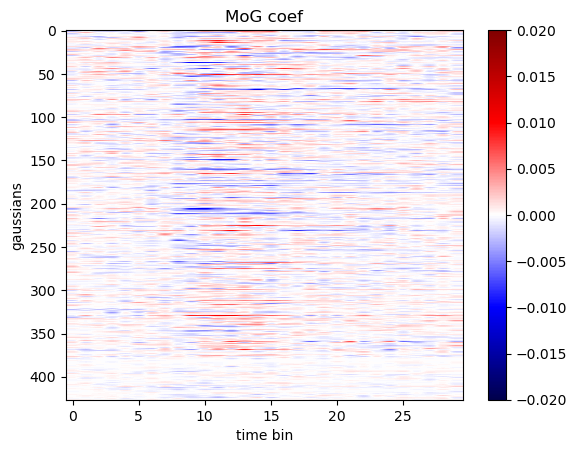

In [31]:
x = clusterless_neural_data.copy()
x = x.reshape(-1, x.shape[1]*x.shape[-1])
y = choices
decoder = LinearSVC(random_state=seed, max_iter=1e4, tol = 0.01, verbose=0)
decoder.fit(x, y.argmax(1))
coef = decoder.coef_.ravel().reshape(clusterless_neural_data.shape[1], 
                                     clusterless_neural_data.shape[-1])

p = plt.imshow(coef, aspect='auto', cmap='seismic', vmin=-0.02, vmax=0.02)
plt.title('MoG coef')
plt.xlabel('time bin')
plt.ylabel('gaussians')
plt.colorbar()
plt.show()